<a href="https://colab.research.google.com/github/MatthewZhang473/Python-programming/blob/master/Ascending_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This Program is to used to find the height of a balloon as a function of time, the ascend rate is also caluclated

## Instruction:
You may change the some parameters, including:  
1) mass of Helium used  
2) mass of the payload  

## Some data may need double check, including:   
1) The function of atmospheric pressure & Temperature, based on https://www.grc.nasa.gov/www/k-12/airplane/atmosmet.html  
2) The drag coefficient Cd: https://en.wikipedia.org/wiki/Drag_coefficient  

## One thing I just realized is that at 30,000 m, the volumn of helium of 1 kg is over 600 m3, which I think is too big


In [ ]:
# Define the constants and all complementary functions

import numpy as np
import scipy as sp
import math
import matplotlib
import matplotlib.pyplot as plt
!pip install ambiance
from ambiance import Atmosphere

from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d

# First define complementary function needed in the calculation
# Atmospheric Pressure: AP(h)
# Temperature: Theta(h)
# Atmospheric density: AD(h) 
# The expressions and functions are based on https://www.grc.nasa.gov/www/k-12/airplane/atmosmet.html 

def Theta(h):
  # return the atmospheric temperature at given height with unit Kelvin
  if h <= 11000:
    return 273.15 + 15.04 - 0.00649 * h
  elif 11000 < h <= 25000:
    return 273.15 + -56.46
  elif h > 25000:
    return 273.15 + -131.21 + 0.00299 * h
  else:
    return "height value out of range"

def AP(h):
  # return the atmospheric pressure at given height h
  # The unit is in Pascals
  if h <= 11000:
    return 1000 * 101.29 * ((Theta(h))/288.08)**5.256
  elif 11000 < h <= 25000:
    return 1000 * 22.65 * np.exp(1.73 - .000157 * h)
  elif h > 25000:
    return 1000 * 2.488 * ((Theta(h)) / 216.6)**-11.388
  else:
    return "height value out of range"

def AD(h):
  # return the atmospheric density at given height
  # the unit is in kgm-3
  return AP(h) / (1000 * 0.2869 * (Theta(h)))


# Define the data related to the balloon and payload used

m_He = 1.5 # the mass of helium in kg
m_payload = 1 # the mass of payload in kg
m_total = m_He + m_payload
M_He = 4.002602e-3 # molar mass in kg/mol
R = 8.31446261815324
Cd = 0.25 # I am not sure what the Cd should be, it is related to the Reynold number
# http://www.randomengineering.co.uk/Random_Aerospace/Balloons.html

#Also define some secondary fucntions, including:
#Volumn of the balloon, based on PV = nRT：V(h)
#Cross sectional area of the balloon: A(h)
#And, k(h), (the drag force = k * v^2)
def V(h):
  return m_He * R * Theta(h) / (M_He * AP(h))

def A(h):
  return (V(h)**2 * 9 / 16 * np.pi)**(1/3)

# Radius given volume of sphere
def r(volume):
  return np.power(3 / 4 / np.pi * volume, 1/3)

# let r = 5, V = 500/3 pi, A = 25pi

# print((9*np.pi*(500/3 * np.pi)**2/16)**(1/3)) # 78.539 ...
# print(((500/3 * np.pi)**2 * 9 * np.pi)**(1/3)) # 314.1592653589792

def k(h):
  return 1/2 * Cd * A(h) * AD(h)

def g(h):
  return 9.80655

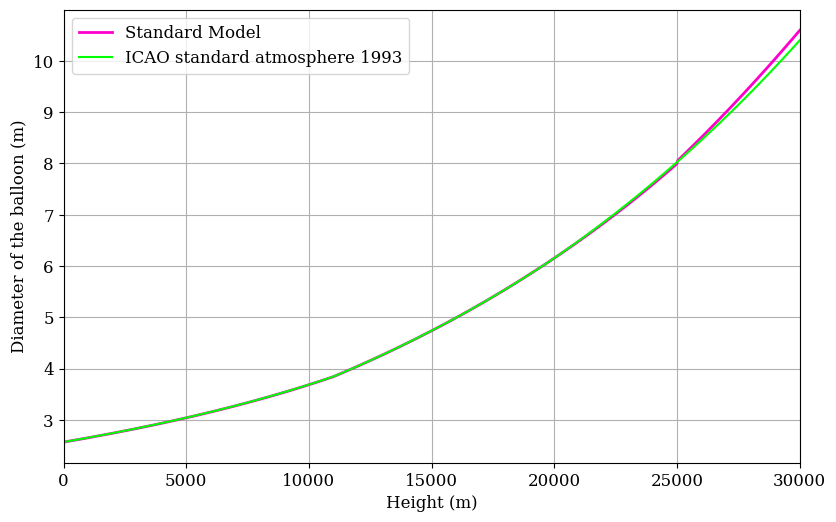

In [ ]:
# This paragraph is for testing functions defined to see if they are valid and continuous, you may not need to run it
#by sketching them from h=0 to h=30000

# create the heights array. with heights increasing by dh each step
N = 1000 + 1
heights = np.linspace(0, 30000, N)

#calculate the values of these funcitons at these heights
The_temperatures = [Theta(h) for h in heights]
The_pressures = [AP(h) for h in heights]
The_densities = [AD(h) for h in heights]
The_Volumes = [V(h) for h in heights]
The_Diameters = [2 * r(V(h)) for h in heights]
The_ks = [k(h) for h in heights]

# plot the results
%matplotlib inline
matplotlib.rcParams.update({'font.size': 12,'font.family':'serif'})

plt.figure(figsize=(9.5,6),dpi=100)
plt.grid()
plt.xlim([0, heights.max()])
plt.xlabel('Height (m)')
plt.ylabel('Diameter of the balloon (m)')

#plt.plot(heights,The_temperatures,'-',linewidth=2,color = [0, 0, 0.8])
plt.plot(heights, The_Diameters,'-',linewidth=2, color = [1, 0, 0.8], label='Standard Model')
Volume = m_He * R * Atmosphere(heights).temperature / (M_He * Atmosphere(heights).pressure)
plt.plot(heights, 2 * r(Volume), color = [0, 1, 0], label='ICAO standard atmosphere 1993')
plt.legend()

In [ ]:
y_0 = [0, 0] # height, velocity

Balloon_pop_diameter = 5
def balloon_pop(t, y): 
  h = y[0] 
  g, rho, T, P = atmos(h) 
  V = m_He * R * T / (M_He * P)
  diameter = 2 * r(V)
  return diameter - Balloon_pop_diameter

balloon_pop.terminal = True
# balloon_pop.direction = 1

In [ ]:
ref_height = np.linspace(y_0[0], Balloon_pop_height + 1000,  (Balloon_pop_height + 1000) // 10 + 1)
atm = Atmosphere(ref_height)

prop = (atm.grav_accel, atm.density, atm.temperature, atm.pressure)

atmos = interp1d(ref_height, prop)

def derivatives_atm(t, y):
  h = y[0]
  velocity = y[1] 

  g, rho, T, P = atmos(h) 
  # Use to not use interpolated values
  # properties = Atmosphere(h) 
  # g = properties.grav_accel
  # rho = properties.density
  # T = properties.temperature
  # P = properties.pressure

  V = m_He * R * T / (M_He * P)
  A = r(V)**2 * np.pi

  upthrust = rho * g * V
  drag = 1/2 * Cd * A * rho * velocity**2

  acceleration = (upthrust - m_total * g - drag) / m_total
  return [velocity, acceleration]

sol_atm = solve_ivp(derivatives_atm, [0, 20000], y_0, events=balloon_pop)

print("Ballon popped at {:.1f} seconds".format(sol_atm.t_events[0][0]))

# calculate the average ascent rate
ascent_rate_atm = sol_atm.y[0, -1] / sol_atm.t[-1]
print("Ballon ascended at {:.1f} m/s".format(ascent_rate_atm))

NameError: ignored

In [ ]:
def derivatives(t, y):
  h = y[0]
  velocity = y[1] 
  acceleration = (AD(h) * g(h) * V(h) - m_total * g(h) - k(h) * (velocity)**2) / m_total
  return [velocity, acceleration]

sol = solve_ivp(derivatives, [0, 20000], y_0, events=balloon_pop)

print("Ballon popped at {:.1f} seconds".format(sol.t_events[0][0]))

# calculate the average ascent rate
ascent_rate = sol.y[0, -1] / sol.t[-1]
print("Ballon ascended at {:.1f} m/s".format(ascent_rate))

In [ ]:
# and print the results

%matplotlib inline
matplotlib.rcParams.update({'font.size': 12,'font.family':'serif'})

plt.figure(figsize=(9.5,6),dpi=100)
plt.grid()
plt.xlabel('Time (s)')
plt.ylabel('Height (m)')

plt.plot(sol.t, sol.y[0],'-',linewidth=2,color = [0, 0, 0.8], label='Standard Model')
plt.plot(sol_atm.t, sol_atm.y[0],'-',linewidth=2, color = [0, 1, 0], label='ICAO standard atmosphere 1993')
plt.legend()

In [ ]:
plt.plot(sol.t, sol.y[1],'-',linewidth=2,color = [0, 0, 0.8])
plt.plot(sol.t, ascent_rate * np.ones(np.size(sol.t)))

In [ ]:
plt.plot(sol.t[10:], sol.y[1, 10:],'-',linewidth=2,color = [0, 0, 0.8])
plt.plot(sol.t, ascent_rate * np.ones(np.size(sol.t)))